![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Visual NLP Handwritten and Signature detection
## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

##Colab Setup

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

## Initialization of spark session


In [ ]:
# Start spark
from sparkocr import start
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 5.3.1
Spark OCR version: 5.3.1rc2



In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

## Load test images

In [ ]:
test_image_path = '/data/docvqa/infographics_image.png'
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/3f8...|2024-03-23 23:49:...| 72547|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+



### Display image


    Image #0:
    Origin: file:/content/3f878eba5bf5d66635a3f2312ca2819c.jpg
    Resolution: 0 dpi
    Width: 736 px
    Height: 508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


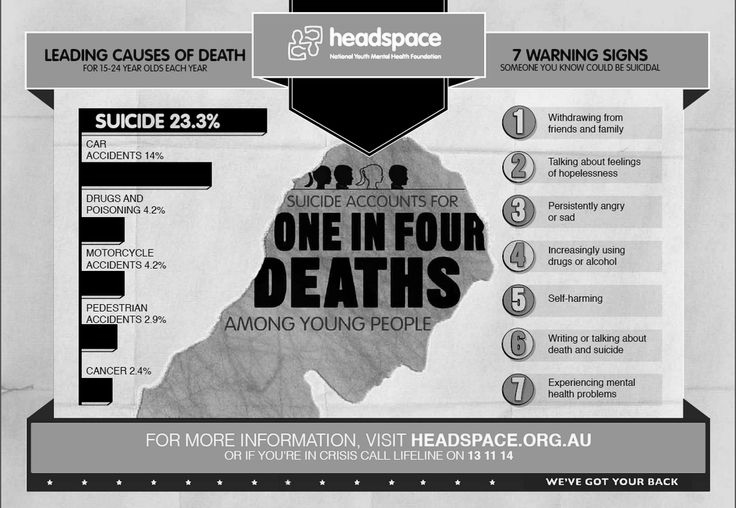

In [ ]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Add some questions!

In [ ]:
questions = [["What percentage of Suicides are caused by Motorcycle accidents?",
  "What percentage of Suicides are caused by pedestrian accidents?",
  "What is fifth warning sign listed here?"]]

questions_df = spark.createDataFrame([questions])
questions_df = questions_df.withColumnRenamed("_1", "questions")

In [ ]:
image_and_questions = bin_df.join(questions_df)
image_and_questions

path,modificationTime,length,content,questions
file:/content/3f8...,2024-03-23 23:49:...,72547,[FF D8 FF E0 00 1...,[What percentage ...


### Define pipeline

In [ ]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("info_docvqa_pix2struct_jsl_base_opt", "en", "clinical/ocr")\
    .setInputCol(["image"])\
    .setOutputCol("answers")\
    .setQuestionsCol("questions")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    visual_question_answering
])

info_docvqa_pix2struct_jsl_base_opt download started this may take some time.
Approximate size to download 457.8 MB


## Call pipeline

In [ ]:
# %%time
from pyspark.sql.functions import explode
results = pipeline.transform(image_and_questions).cache()
results.select(results.answers).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers                                                                                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{[When it finish the Coffee Break? , Who is giving the Introductory Remarks? , Who is going to take part of the individual interviews? ], [  When it finish the Coffee Break,   Laura Secord,   self-harming], [0.09822783, 0.09368795, 0.3912018]}|
+---------------

## Apply single set of questions to images across all rows/images

In [ ]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("info_docvqa_pix2struct_jsl_base_opt", "en", "clinical/ocr")\
    .setQuestions(questions[0])\
    .setOutputCol("answers")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    visual_question_answering
])

info_docvqa_pix2struct_jsl_base_opt download started this may take some time.
Approximate size to download 457.8 MB


In [ ]:
# %%time
from pyspark.sql.functions import explode
results = pipeline.transform(bin_df)
results.select("answers").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers                                                                                                                                                                                                                                                |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{[What percentage of Suicides are caused by Motorcycle accidents? , What percentage of Suicides are caused by pedestrian accidents? , What is fifth warning sign listed here? ], [  4.2%,   2.9%,   self-harming], [0.9581562, 0.98590666, 0.89071125]}|


## LightPipelines

In [ ]:
from sparkocr.base import LightPipeline
lp = LightPipeline(pipeline)

In [ ]:
%%time
lp.fromLocalPath(test_image_path)

CPU times: user 302 ms, sys: 36.2 ms, total: 338 ms
Wall time: 1min 9s


[{'image': ImageOutput(path: 3f878eba5bf5d66635a3f2312ca2819c.jpg, exception: None),
  'answers': AnswersOutput(questions_and_answers: [{'score': 0.9581562, 'question': 'What percentage of Suicides are caused by Motorcycle accidents? ', 'answer': '  4.2%'}, {'score': 0.98590666, 'question': 'What percentage of Suicides are caused by pedestrian accidents? ', 'answer': '  2.9%'}, {'score': 0.89071125, 'question': 'What is fifth warning sign listed here? ', 'answer': '  self-harming'}])}]